In [35]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import xgboost as xgb

In [2]:
trips = pq.read_table('yellow_tripdata_2024-01.parquet')
df_jan = trips.to_pandas()

In [3]:
del trips

In [4]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [5]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [6]:
# Cast columns
df_jan['tpep_pickup_datetime'] = pd.to_datetime(df_jan['tpep_pickup_datetime'], errors='coerce')
df_jan['tpep_dropoff_datetime'] = pd.to_datetime(df_jan['tpep_dropoff_datetime'], errors='coerce')
df_jan["passenger_count"] = pd.to_numeric(df_jan["passenger_count"], downcast="integer", errors="coerce")
df_jan["trip_distance"] = pd.to_numeric(df_jan["trip_distance"], errors="coerce")
df_jan["RatecodeID"] = pd.to_numeric(df_jan["RatecodeID"], downcast="integer", errors="coerce")
df_jan["PULocationID"] = pd.to_numeric(df_jan["PULocationID"], downcast="integer", errors="coerce")
df_jan["DOLocationID"] = pd.to_numeric(df_jan["DOLocationID"], downcast="integer", errors="coerce")
df_jan["payment_type"] = pd.to_numeric(df_jan["payment_type"], downcast="integer", errors="coerce")
df_jan["fare_amount"] = pd.to_numeric(df_jan["fare_amount"], errors="coerce")
df_jan["extra"] = pd.to_numeric(df_jan["extra"], errors="coerce")
df_jan["mta_tax"] = pd.to_numeric(df_jan["mta_tax"], errors="coerce")
df_jan["tip_amount"] = pd.to_numeric(df_jan["tip_amount"], errors="coerce")
df_jan["tolls_amount"] = pd.to_numeric(df_jan["tolls_amount"], errors="coerce")
df_jan["improvement_surcharge"] = pd.to_numeric(df_jan["improvement_surcharge"], errors="coerce")
df_jan["total_amount"] = pd.to_numeric(df_jan["total_amount"], errors="coerce")
df_jan["congestion_surcharge"] = pd.to_numeric(df_jan["congestion_surcharge"], errors="coerce")
df_jan["Airport_fee"] = pd.to_numeric(df_jan["Airport_fee"], errors="coerce")

In [7]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [8]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int16         
 8   DOLocationID           int16         
 9   payment_type           int8          
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [9]:
# Trip journey in hours
df_jan['journey_duration_in_hrs'] = (df_jan['tpep_dropoff_datetime'] - df_jan['tpep_pickup_datetime']).dt.total_seconds() / 3600.0

In [10]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,journey_duration_in_hrs
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,0.330000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,0.110000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,0.298611
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,0.138333
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,0.101667


# Aggregating Hours for Entire Month altogether

In [11]:
# Just summarize how many trips
df_agg = df_jan[["tpep_pickup_datetime"]].copy()
df_agg.head(5) 

,tpep_pickup_datetime
0,2024-01-01 00:57:55
1,2024-01-01 00:03:00
2,2024-01-01 00:17:06
3,2024-01-01 00:36:38
4,2024-01-01 00:46:51


In [13]:
df_agg["hour"] = df_agg["tpep_pickup_datetime"].dt.hour
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 2 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   hour                  int32         
dtypes: datetime64[us](1), int32(1)
memory usage: 33.9 MB


In [14]:
df_agg.tail(5)

,tpep_pickup_datetime,hour
2964619,2024-01-31 23:45:59,23
2964620,2024-01-31 23:13:07,23
2964621,2024-01-31 23:19:00,23
2964622,2024-01-31 23:07:23,23
2964623,2024-01-31 23:58:25,23


In [15]:
df_agg["hour"].unique()

array([ 0, 23,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 22, 19, 20, 21], dtype=int32)

In [16]:
# Aggregate by hour
df_trip_counts_in_hour = df_agg.groupby("hour").size().reset_index(name="trip_counts")

In [17]:
df_trip_counts_in_hour.head(5)

,hour,trip_counts
0,0,79094
1,1,53627
2,2,37517
3,3,24811
4,4,16742


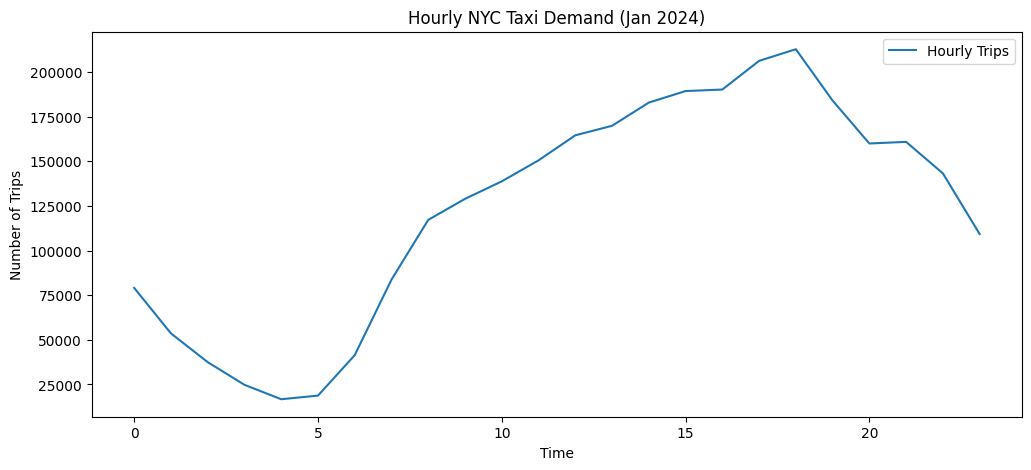

In [18]:
# Plot hourly demand
plt.figure(figsize=(12, 5))
plt.plot(df_trip_counts_in_hour["hour"].to_numpy(), df_trip_counts_in_hour["trip_counts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

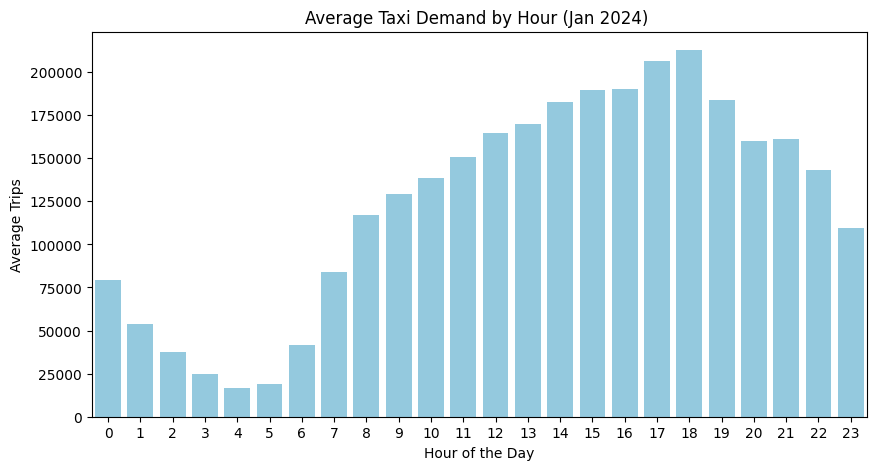

In [19]:
# Plot demand pattern by hour of the day
plt.figure(figsize=(10, 5))
sns.barplot(x=df_trip_counts_in_hour["hour"].to_numpy(), y=df_trip_counts_in_hour["trip_counts"].to_numpy(), color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Trips")
plt.title("Average Taxi Demand by Hour (Jan 2024) ")
plt.show()


In [20]:
df_trip_counts_in_hour["trip_counts"]

0      79094
1      53627
2      37517
3      24811
4      16742
5      18764
6      41429
7      83719
8     117209
9     128970
10    138778
11    150542
12    164559
13    169903
14    182898
15    189359
16    190201
17    206257
18    212788
19    184032
20    159989
21    160888
22    143261
23    109287
Name: trip_counts, dtype: int64

In [21]:
# Train SARIMA model
sarima_model = SARIMAX(df_trip_counts_in_hour["trip_counts"].to_numpy(), order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


# Daily One-Hour Block

In [11]:
# Lets just get Jan 2024
df_agg = df_jan[["tpep_pickup_datetime"]].copy()
print(len(df_agg))
df_agg = df_agg.loc[df_agg["tpep_pickup_datetime"] > "2023-12-31 23:59:59"]
df_agg.reset_index(drop=True, inplace=True)
print(len(df_agg))

2964624
2964609


In [12]:
print(df_agg["tpep_pickup_datetime"].min(), df_agg["tpep_pickup_datetime"].max())

2024-01-01 00:00:00 2024-02-01 00:01:15


In [13]:
# df_agg = df_jan[["tpep_pickup_datetime"]].copy()
df_agg["date"] = df_agg["tpep_pickup_datetime"].dt.date.astype(str)
df_agg["hour"] = df_agg["tpep_pickup_datetime"].dt.hour.astype(str)
df_agg.tail(5)

,tpep_pickup_datetime,date,hour
2964604,2024-01-31 23:45:59,2024-01-31,23
2964605,2024-01-31 23:13:07,2024-01-31,23
2964606,2024-01-31 23:19:00,2024-01-31,23
2964607,2024-01-31 23:07:23,2024-01-31,23
2964608,2024-01-31 23:58:25,2024-01-31,23


In [14]:
print(df_agg["tpep_pickup_datetime"].min(), df_agg["tpep_pickup_datetime"].max())

2024-01-01 00:00:00 2024-02-01 00:01:15


In [15]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964609 entries, 0 to 2964608
Data columns (total 3 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   date                  object        
 2   hour                  object        
dtypes: datetime64[us](1), object(2)
memory usage: 67.9+ MB


In [16]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964609 entries, 0 to 2964608
Data columns (total 3 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   date                  object        
 2   hour                  object        
dtypes: datetime64[us](1), object(2)
memory usage: 67.9+ MB


In [17]:
# Groupby
df_agg = df_agg.groupby(["date", "hour"]).size().reset_index(name="daily_hourly_tripcounts")
# df_agg["date_hour"] = str(df_agg["date"]) + '_' + df_agg["hour"].astype(str)
df_agg.tail(5)

,date,hour,daily_hourly_tripcounts
740,2024-01-31,6,1582
741,2024-01-31,7,3647
742,2024-01-31,8,5244
743,2024-01-31,9,5333
744,2024-02-01,0,3


In [18]:
df_agg["date_hour"] = df_agg["date"] + '_' + df_agg["hour"]

In [19]:
df_agg.tail(5)

,date,hour,daily_hourly_tripcounts,date_hour
740,2024-01-31,6,1582,2024-01-31_6
741,2024-01-31,7,3647,2024-01-31_7
742,2024-01-31,8,5244,2024-01-31_8
743,2024-01-31,9,5333,2024-01-31_9
744,2024-02-01,0,3,2024-02-01_0


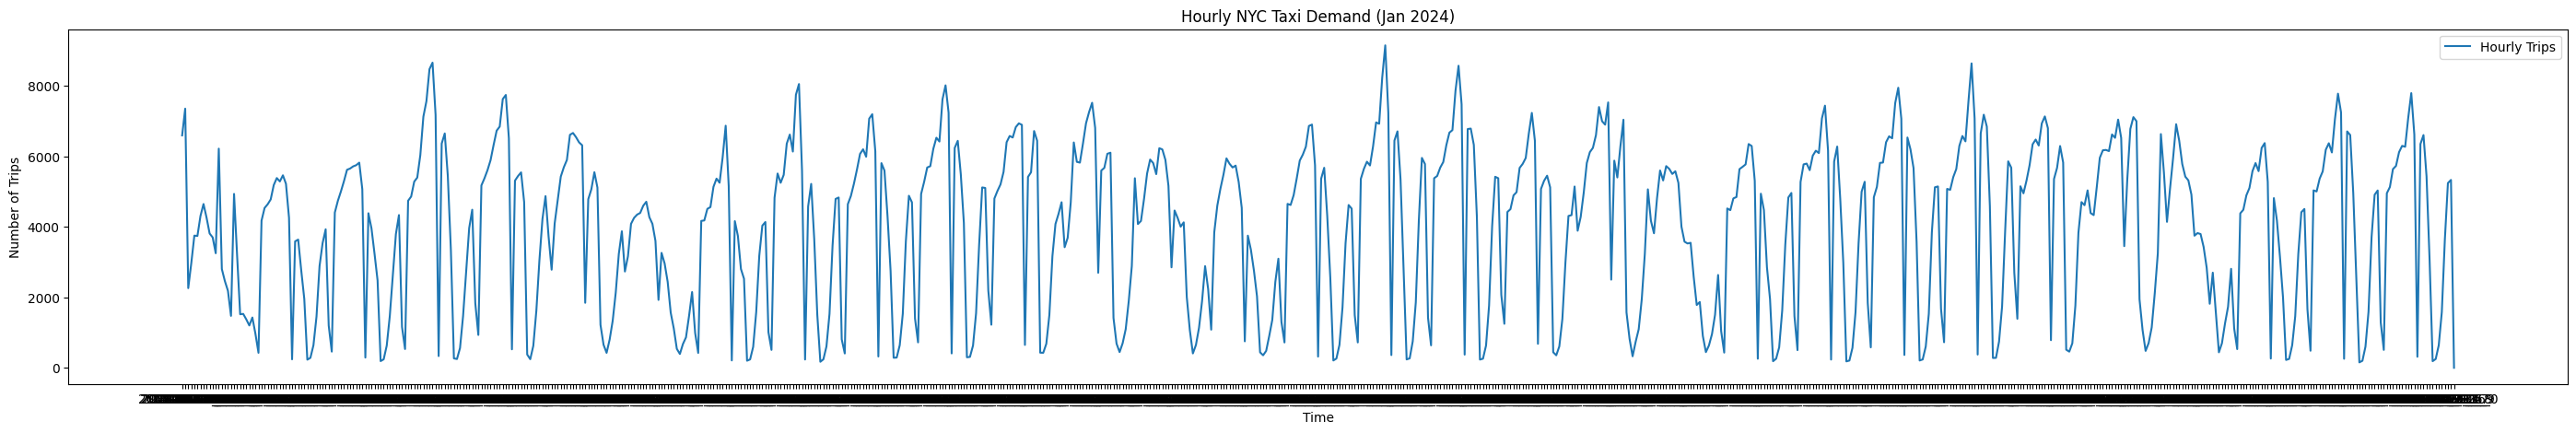

In [20]:
# Plot hourly demand
plt.figure(figsize=(35, 5))
plt.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

In [21]:
# Convert 'date_hour' column to datetime
df_agg['datetime'] = pd.to_datetime(df_agg['date_hour'].str.replace('_', ' '), format='%Y-%m-%d %H')
df_agg

,date,hour,daily_hourly_tripcounts,date_hour,datetime
0,2024-01-01,0,6596,2024-01-01_0,2024-01-01 00:00:00
1,2024-01-01,1,7355,2024-01-01_1,2024-01-01 01:00:00
2,2024-01-01,10,2263,2024-01-01_10,2024-01-01 10:00:00
3,2024-01-01,11,2974,2024-01-01_11,2024-01-01 11:00:00
4,2024-01-01,12,3753,2024-01-01_12,2024-01-01 12:00:00
...,...,...,...,...,...
740,2024-01-31,6,1582,2024-01-31_6,2024-01-31 06:00:00
741,2024-01-31,7,3647,2024-01-31_7,2024-01-31 07:00:00
742,2024-01-31,8,5244,2024-01-31_8,2024-01-31 08:00:00
743,2024-01-31,9,5333,2024-01-31_9,2024-01-31 09:00:00


In [22]:
# Define the hour for which labels should be displayed
selected_hour = 17  

# Set x-axis labels: only show the selected hour, others remain empty
filtered_labels = [d.strftime('%Y-%m-%d_%H') if d.hour == selected_hour else "" for d in df_agg['datetime']]


In [23]:
filtered_labels

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-01_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-02_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-03_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-04_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-05_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-06_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-07_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-08_17',
 '',
 

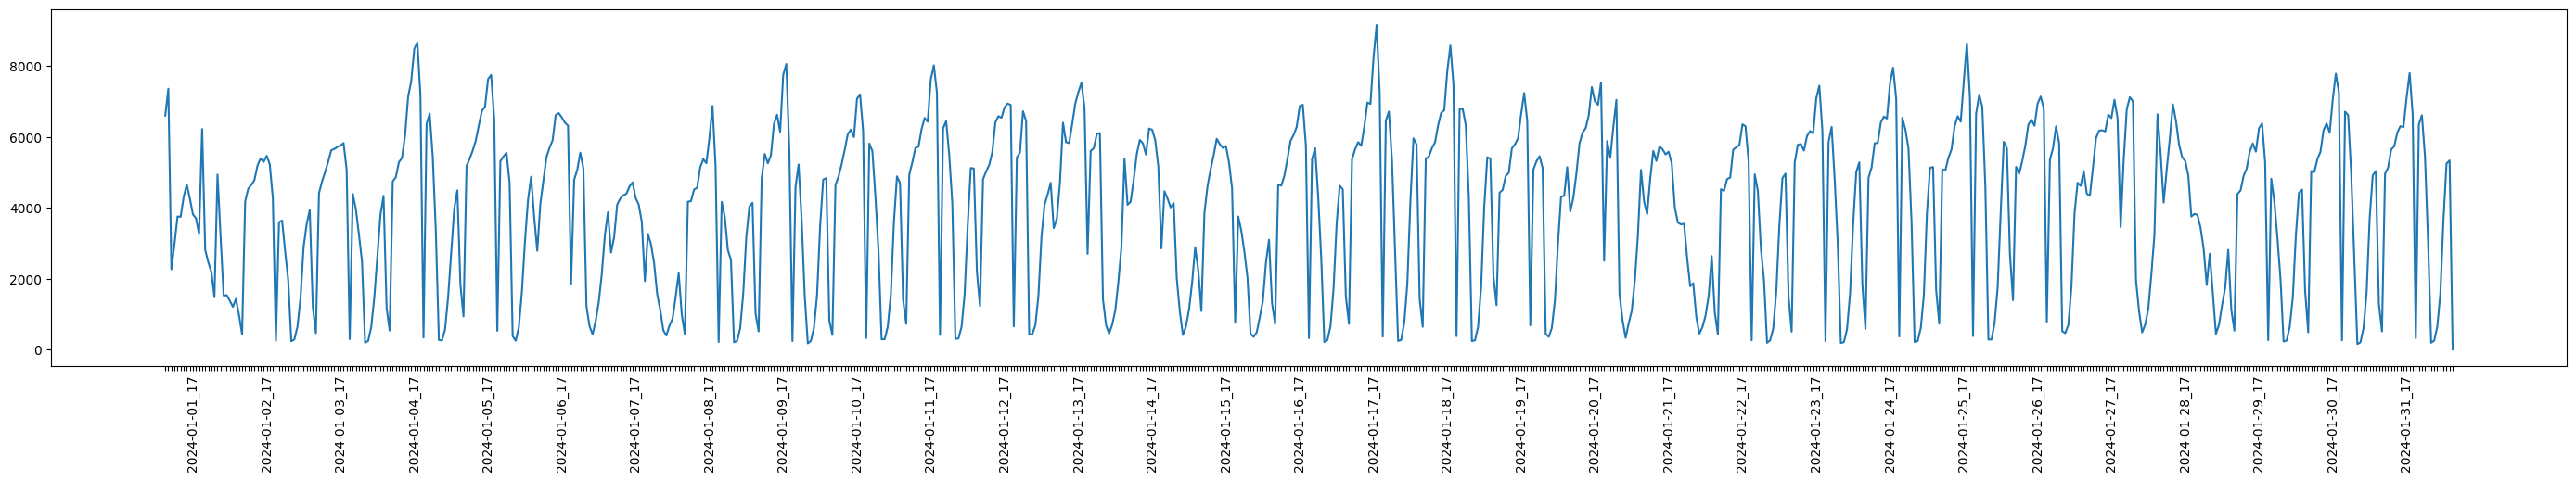

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(35, 5))
ax.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy())

# Apply the modified x-axis labels
ax.set_xticks(df_agg['date_hour'])
ax.set_xticklabels(filtered_labels, rotation=90, ha='center')

# Show the plot
plt.show()

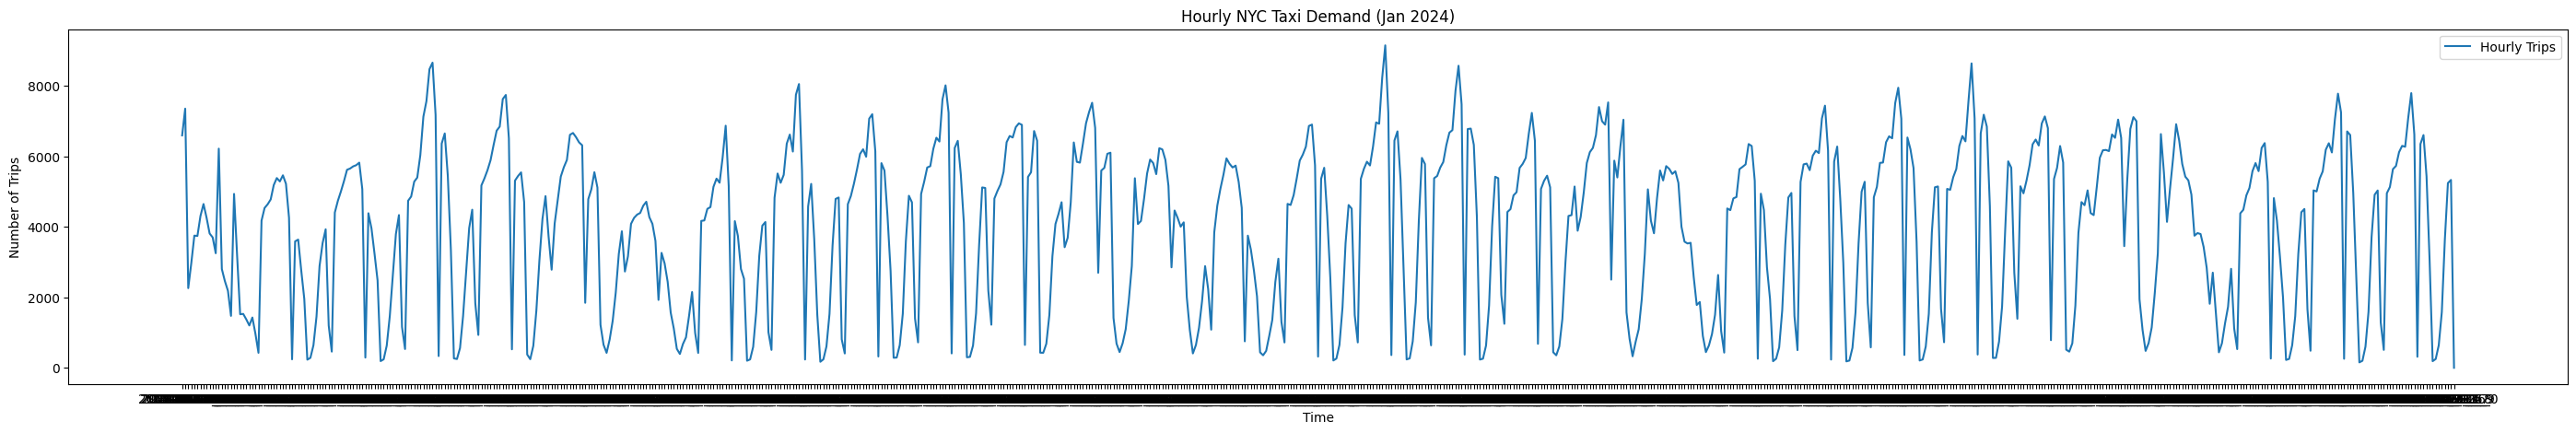

In [25]:
# Plot hourly demand
plt.figure(figsize=(35, 5))
plt.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

In [12]:
# Lets just get Jan 2024
df_agg = df_jan[["tpep_pickup_datetime"]].copy()
print(len(df_agg))
df_agg = df_agg.loc[df_agg["tpep_pickup_datetime"] > "2023-12-31 23:59:59"]
df_agg.reset_index(drop=True, inplace=True)
print(len(df_agg))

2964624
2964609


In [13]:
df_agg.head(5)

,tpep_pickup_datetime
0,2024-01-01 00:57:55
1,2024-01-01 00:03:00
2,2024-01-01 00:17:06
3,2024-01-01 00:36:38
4,2024-01-01 00:46:51


In [14]:
df_hourly = df_agg.resample('h', on='tpep_pickup_datetime').size().reset_index(name="hourly_pickups")

In [15]:
df_hourly.head(5)

,tpep_pickup_datetime,hourly_pickups
0,2024-01-01 00:00:00,6596
1,2024-01-01 01:00:00,7355
2,2024-01-01 02:00:00,6220
3,2024-01-01 03:00:00,4936
4,2024-01-01 04:00:00,3188


In [16]:
print(len(df_hourly))

745


In [17]:
# LEts proceed without check
train_size = int(0.8 * len(df_hourly))
print(train_size)

596


In [18]:
train, test = df_hourly.iloc[0:train_size, :], df_hourly.iloc[train_size:len(df_hourly), :] 

In [19]:
train

,tpep_pickup_datetime,hourly_pickups
0,2024-01-01 00:00:00,6596
1,2024-01-01 01:00:00,7355
2,2024-01-01 02:00:00,6220
3,2024-01-01 03:00:00,4936
4,2024-01-01 04:00:00,3188
...,...,...
591,2024-01-25 15:00:00,6579
592,2024-01-25 16:00:00,6427
593,2024-01-25 17:00:00,7577
594,2024-01-25 18:00:00,8639


In [20]:
test

,tpep_pickup_datetime,hourly_pickups
596,2024-01-25 20:00:00,6653
597,2024-01-25 21:00:00,7184
598,2024-01-25 22:00:00,6847
599,2024-01-25 23:00:00,4588
600,2024-01-26 00:00:00,2697
...,...,...
740,2024-01-31 20:00:00,6351
741,2024-01-31 21:00:00,6606
742,2024-01-31 22:00:00,5435
743,2024-01-31 23:00:00,3061


In [21]:
train.set_index("tpep_pickup_datetime", inplace=True)
test.set_index("tpep_pickup_datetime", inplace=True)

In [22]:
train

,hourly_pickups
tpep_pickup_datetime,
2024-01-01 00:00:00,6596
2024-01-01 01:00:00,7355
2024-01-01 02:00:00,6220
2024-01-01 03:00:00,4936
2024-01-01 04:00:00,3188
...,...
2024-01-25 15:00:00,6579
2024-01-25 16:00:00,6427
2024-01-25 17:00:00,7577


In [23]:
# Train SARIMA model
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit()

/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40967D+00    |proj g|=  1.77859D-01


 This problem is unconstrained.



At iterate    5    f=  7.31000D+00    |proj g|=  2.19740D-02

At iterate   10    f=  7.29806D+00    |proj g|=  1.78496D-02

At iterate   15    f=  7.26396D+00    |proj g|=  6.51311D-02

At iterate   20    f=  7.25359D+00    |proj g|=  2.35243D-03

At iterate   25    f=  7.25281D+00    |proj g|=  1.48122D-03

At iterate   30    f=  7.25270D+00    |proj g|=  3.23276D-03

At iterate   35    f=  7.24597D+00    |proj g|=  3.58269D-02

At iterate   40    f=  7.23045D+00    |proj g|=  1.46228D-02

At iterate   45    f=  7.22964D+00    |proj g|=  5.02447D-03

At iterate   50    f=  7.22952D+00    |proj g|=  3.22700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# sarima_result.forecast(start=test)
# test.set_index("tpep_pickup_datetime")
test.index[0]

Timestamp('2024-01-25 20:00:00')

In [25]:
forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])

In [26]:
type(forecast)

pandas.core.series.Series

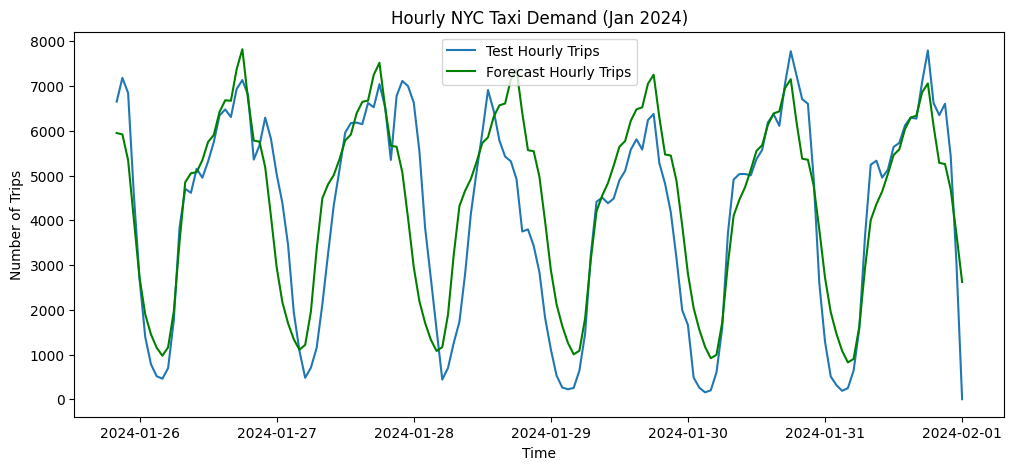

In [27]:
# Plot hourly demand
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["hourly_pickups"], label="Test Hourly Trips")
plt.plot(forecast.index, forecast.values, label="Forecast Hourly Trips", color="green")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

In [28]:
forecast.values

array([5951.50020144, 5921.12261604, 5346.06121206, 4034.34604113,
       2720.3550701 , 1900.03021223, 1453.92425607, 1154.9810613 ,
        974.83944056, 1162.6031463 , 1965.58776962, 3514.4212857 ,
       4852.23577787, 5052.58913955, 5077.34393174, 5345.72265557,
       5751.84132375, 5908.32058293, 6420.93621516, 6683.77961876,
       6672.24094558, 7376.25399678, 7824.3963652 , 6697.83620557,
       5783.71847296, 5758.38570348, 5188.32151834, 4100.84992462,
       2957.81263564, 2174.78602377, 1700.43443242, 1342.66090757,
       1109.17577721, 1217.64232459, 1962.65799836, 3341.91852267,
       4492.0951953 , 4803.23756966, 5010.2617019 , 5364.67809679,
       5784.52145178, 5919.00309186, 6390.43640203, 6647.69988802,
       6677.0746743 , 7251.18101482, 7520.51943851, 6519.62871981,
       5668.24729777, 5644.38397811, 5075.77537874, 4053.62126928,
       2960.37922784, 2188.21681831, 1705.63786162, 1330.72828674,
       1081.70530289, 1167.07423937, 1895.20476532, 3225.07220

In [36]:
# Calculate Mean Squared Error

# forecast.values
# test["hourly_pickups"].to_numpy()
print(test["hourly_pickups"].to_numpy().shape, forecast.values.shape)
print(root_mean_squared_error(test["hourly_pickups"].to_numpy(), forecast.values))

(149,) (149,)
1160.571309720726


In [33]:
test.index

DatetimeIndex(['2024-01-25 20:00:00', '2024-01-25 21:00:00',
               '2024-01-25 22:00:00', '2024-01-25 23:00:00',
               '2024-01-26 00:00:00', '2024-01-26 01:00:00',
               '2024-01-26 02:00:00', '2024-01-26 03:00:00',
               '2024-01-26 04:00:00', '2024-01-26 05:00:00',
               ...
               '2024-01-31 15:00:00', '2024-01-31 16:00:00',
               '2024-01-31 17:00:00', '2024-01-31 18:00:00',
               '2024-01-31 19:00:00', '2024-01-31 20:00:00',
               '2024-01-31 21:00:00', '2024-01-31 22:00:00',
               '2024-01-31 23:00:00', '2024-02-01 00:00:00'],
              dtype='datetime64[us]', name='tpep_pickup_datetime', length=149, freq=None)

In [34]:
forecast.index

DatetimeIndex(['2024-01-25 20:00:00', '2024-01-25 21:00:00',
               '2024-01-25 22:00:00', '2024-01-25 23:00:00',
               '2024-01-26 00:00:00', '2024-01-26 01:00:00',
               '2024-01-26 02:00:00', '2024-01-26 03:00:00',
               '2024-01-26 04:00:00', '2024-01-26 05:00:00',
               ...
               '2024-01-31 15:00:00', '2024-01-31 16:00:00',
               '2024-01-31 17:00:00', '2024-01-31 18:00:00',
               '2024-01-31 19:00:00', '2024-01-31 20:00:00',
               '2024-01-31 21:00:00', '2024-01-31 22:00:00',
               '2024-01-31 23:00:00', '2024-02-01 00:00:00'],
              dtype='datetime64[ns]', length=149, freq='h')

# XGBoost

In [51]:
# Lets do feature engineering
df_xgboost = df_hourly.copy()

In [52]:
df_xgboost.head(5)

,tpep_pickup_datetime,hourly_pickups
0,2024-01-01 00:00:00,6596
1,2024-01-01 01:00:00,7355
2,2024-01-01 02:00:00,6220
3,2024-01-01 03:00:00,4936
4,2024-01-01 04:00:00,3188


In [53]:
# Create time-based features
df_xgboost["hour"] = df_xgboost["tpep_pickup_datetime"].dt.hour.astype(int)
df_xgboost["dayofweek"] = df_xgboost["tpep_pickup_datetime"].dt.dayofweek.astype(int)
df_xgboost["dayofmonth"] = df_xgboost["tpep_pickup_datetime"].dt.day.astype(int)
df_xgboost["month"] = df_xgboost["tpep_pickup_datetime"].dt.month.astype(int)

In [54]:
# Create Lagging features
df_xgboost["hourly_pickups_lag_1"] = df_xgboost["hourly_pickups"].shift(1)

# Drop NA
df_xgboost.dropna(inplace=True)

In [55]:
df_xgboost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 1 to 744
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tpep_pickup_datetime  744 non-null    datetime64[us]
 1   hourly_pickups        744 non-null    int64         
 2   hour                  744 non-null    int64         
 3   dayofweek             744 non-null    int64         
 4   dayofmonth            744 non-null    int64         
 5   month                 744 non-null    int64         
 6   hourly_pickups_lag_1  744 non-null    float64       
dtypes: datetime64[us](1), float64(1), int64(5)
memory usage: 46.5 KB


In [56]:
df_xgboost.head(5)

,tpep_pickup_datetime,hourly_pickups,hour,dayofweek,dayofmonth,month,hourly_pickups_lag_1
1,2024-01-01 01:00:00,7355,1,0,1,1,6596.0
2,2024-01-01 02:00:00,6220,2,0,1,1,7355.0
3,2024-01-01 03:00:00,4936,3,0,1,1,6220.0
4,2024-01-01 04:00:00,3188,4,0,1,1,4936.0
5,2024-01-01 05:00:00,1522,5,0,1,1,3188.0


In [57]:
# Define features and target variable
X = df_xgboost[["hour", "dayofweek", "dayofmonth", "month", "hourly_pickups_lag_1"]]
y = df_xgboost["hourly_pickups"]

# Split into training and testing sets
train_size = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(X_train.shape, X_test.shape)

(595, 5) (149, 5)


In [58]:
X_train.head(5)

,hour,dayofweek,dayofmonth,month,hourly_pickups_lag_1
1,1,0,1,1,6596.0
2,2,0,1,1,7355.0
3,3,0,1,1,6220.0
4,4,0,1,1,4936.0
5,5,0,1,1,3188.0


In [59]:
y_train.head(5)

1    7355
2    6220
3    4936
4    3188
5    1522
Name: hourly_pickups, dtype: int64

In [60]:
X_test

,hour,dayofweek,dayofmonth,month,hourly_pickups_lag_1
596,20,3,25,1,7081.0
597,21,3,25,1,6653.0
598,22,3,25,1,7184.0
599,23,3,25,1,6847.0
600,0,4,26,1,4588.0
...,...,...,...,...,...
740,20,2,31,1,6622.0
741,21,2,31,1,6351.0
742,22,2,31,1,6606.0
743,23,2,31,1,5435.0


In [61]:
y_test

596    6653
597    7184
598    6847
599    4588
600    2697
       ... 
740    6351
741    6606
742    5435
743    3061
744       3
Name: hourly_pickups, Length: 149, dtype: int64

In [62]:
# Initialize and train the model
xgb_model = xgb.XGBRegressor(n_estimators=20, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
# Predict on test data
y_pred = xgb_model.predict(X_test)

In [71]:
# y_test.to_numpy()
# y_pred

# For plotting
y_test

596    6653
597    7184
598    6847
599    4588
600    2697
       ... 
740    6351
741    6606
742    5435
743    3061
744       3
Name: hourly_pickups, Length: 149, dtype: int64

In [69]:
print(root_mean_squared_error(y_test.to_numpy(), y_pred))

596.0243530273438


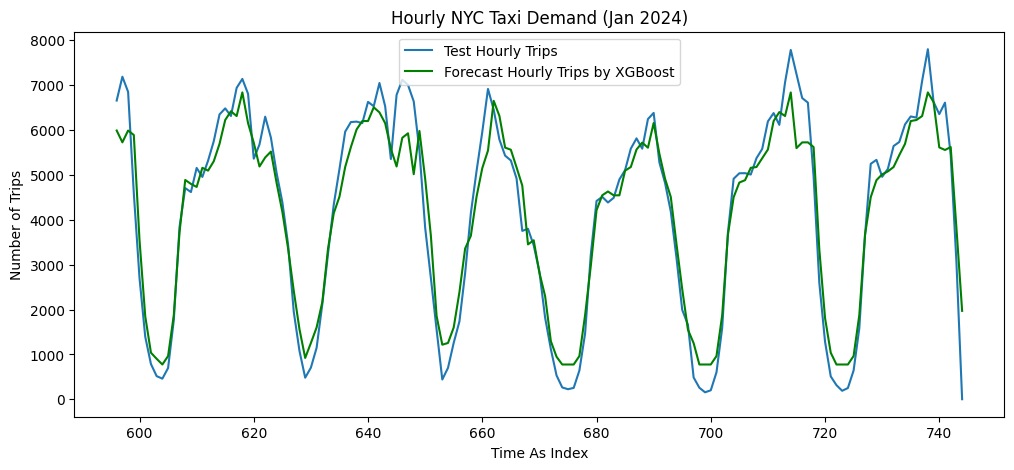

In [72]:
# Plot hourly demand
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.to_numpy(), label="Test Hourly Trips")
plt.plot(y_test.index, y_pred, label="Forecast Hourly Trips by XGBoost", color="green")
plt.xlabel("Time As Index")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

In [ ]:
# Lets do LSTM
